<h1 align="center"> Part 2</h1>
<h1 align="center">Researcher proposes a research question</h1>
<center><img src="../CCAIO workshop imgs/steps/20.svg" align="center" style="width:90%; align:center"/></center>

## 2.1 Gets access to the Domain Server

<center><img src="../CCAIO workshop imgs/steps/21.svg" align="center" style="width:90%"/></center>


In [1]:
import syft as sy

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/ina/Repos/demo/demo


Logged into <dailymotion_node: High side Domain> as <oscarwilde@skywalker.net>


<DomainClient: dailymotion_node>
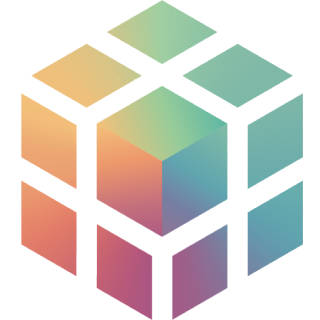

In [2]:
researcher_client = sy.login(url='http://localhost:8087', email='oscarwilde@skywalker.net', password='oscars_house')
researcher_client

## 2.2 Proposing a research question

<center><img src="../CCAIO workshop imgs/steps/22.svg" align="center" style="width:90%"/></center>

### Pre-requisite: Understand the available data assets

In [3]:
researcher_client.datasets[0]

syft.service.dataset.dataset.Dataset

In [4]:
asset = researcher_client.datasets[0].assets[0]
asset

syft.service.dataset.dataset.Asset

<br>
<br>
<br>

## Propose a research question

Once familiar with the dataset schema, the researcher proposes a question to answer. 

<center><img src="../CCAIO workshop imgs/steps/exp.svg" align="center" style="width:90%"/></center>


**Highly suggestive content** = posts flagged by internal AI algorithms and human raters to contain violent or sexual artifacts

### Proposing a project

- introduces the research questions to be studied
- must align with motivation stated during background checks/legal agreements

In [5]:
project_proposal = sy.Project(
    name="Suggestive content analysis",
    description="""
    This project aims to study the relationship between suggestiveness scores and the degree to which the
    algorithms deployed by DailyMotion are amplifying such content.""",
    members=[researcher_client]  # Note: A project could be conducted by multiple researchers
)

project = project_proposal.start()

In [6]:
project

syft.service.project.project.Project

<br>
<br>

## Proposing the audit code

A project consists of multiple audit code requests that implement the researcher's approach to answering the proposed question.

### How do code requests work?
An code request is a remote code execution request that is:
- *written* by the researcher on their own machine
- *adheres* to the data owner organisation's use/mis-use policies
- *tested* against the fake counterpart of the data for correctness
- *submitted* for review, with the purpose of being run on the private data

<br>

### What are data usage/release policies?
<center><img src="../CCAIO workshop imgs/steps/-3.svg" align="center" style="width:90%"/></center>


**we assume the above were shared with the researchers when onboarded*

## Designing the 1st code request

### Are most popular videos more suggestive?
**Methodology:**
- define *popular* as the top-10% videos by number of views within the platform
- investigate if the avg suggestiveness score of popular videos is higher that the platform's average
- investigate if any of the algorithms contributes more to the popularity of suggestive content
- use differential privacy to understand the patterns of the data, but protect the information about individual videos in the data

In [7]:
@sy.syft_function_single_use(df=asset)
def suggestiveness_in_top10pp_videos(df):
    from opendp.measurements import make_base_laplace
    from opendp.mod import enable_features
    from io import BytesIO
    import numpy as np
    import matplotlib.pyplot as plt

    def most_popular_videos_in_dataset(data):
        # Select the top 10% of the videos by number of recommendations
        count_top10p = int(0.1 * data.size)
        top10_threshold = data['recommendations'].nlargest(count_top10p).iloc[-1].astype(float)  
        top_posts = data[data['recommendations'] > top10_threshold]
        return top_posts

    # Select most popular videos (top 10%)
    top_posts = most_popular_videos_in_dataset(df)
    top_posts_per_algo = [most_popular_videos_in_dataset(df[df['algo'] == x]) for x in ['A', 'B', 'C']]
    
    # Adding DP noise    
    enable_features("contrib")
    base_lap_vec_sugg = make_base_laplace(scale=1e-4, D="VectorDomain<AllDomain<float>>")
    to_plot = [base_lap_vec_sugg(x['suggestive'].to_list()) for x in [df, top_posts] + top_posts_per_algo]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12,8))
    bp = ax.boxplot(to_plot, sym='k+', positions=np.arange(len(to_plot)) + 1, vert=True, patch_artist=True, notch=True)

    colors = ['pink', 'lightblue', 'lightgreen', 'lavender']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.yaxis.grid(True)
    ax.set_title('Most popular videos\' sugestiveness', size=18)
    ax.set_ylabel('Suggestiveness ', fontsize=16)
    ax.set_xticks(range(7),['', 'All videos', 'Top posts', 'Top posts Alg.1', 'Top posts Alg.2', 'Top posts Alg.3', ''], size=14)

    figfile = BytesIO()
    plt.savefig(figfile, format='png')
    return figfile

Syft function 'suggestiveness_in_top10pp_videos' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


## Running 1st code request

We can run the above code against the mock data and check our code for corectness.

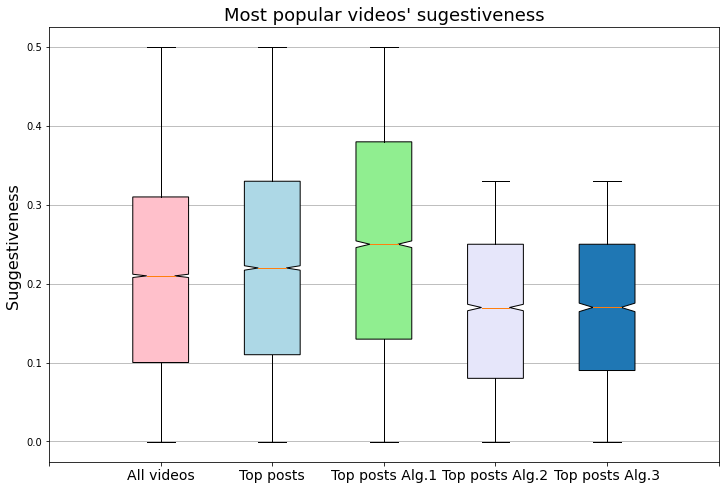

In [8]:
suggestiveness_in_top10pp_videos(df=asset.mock)

If it corresponds to what we would like to learn from private data, we continue further.
Otherwise, we go backand refine our code request till it does.

## Designing the 2st code request

### Are certain videos treated unusual by any of the algortihms?
**Methodology:**
- for each algorithm:
    - we fit an estimator on the relation between suggestiveness score and the number of recommendations
    - we extract the outliers
- we inspect the extracted videos manually and look for unusual patterns in the behaviour of the algorithms

In [9]:
@sy.syft_function_single_use(df=asset)
def get_outliers(df, x_axis = 'suggestive', y_axis = 'recommendations', category_seriesname = 'algo', threshold = 6):
    import numpy as np
    import pandas as pd
    from sklearn.covariance import MinCovDet

    # Pick out outliers per category
    categories = sorted(df[category_seriesname].unique())
    results = []
    for category_label in categories:
        df_outliers = df[df[category_seriesname] == category_label]
        X = df_outliers[[x_axis, y_axis]].to_numpy()

        # fit a MCD robust estimator to data
        robust_cov = MinCovDet().fit(X)

        # Outliers
        df_outliers = df_outliers[df_outliers[x_axis] > robust_cov.location_[0]]
        df_outliers = df_outliers[df_outliers[y_axis] > robust_cov.location_[1]]

        # Filter for data in the upper right quadrant
        X = X[np.logical_and(X[:,0] > robust_cov.location_[0], X[:,1] > robust_cov.location_[1])]

        # Compute Mahalanobis distance (squared)
        df_outliers['distance'] = robust_cov.mahalanobis(np.c_[df_outliers[x_axis].to_numpy(),
                                        df_outliers[y_axis].to_numpy()])

        # Only consider points exceeding the threshold number of standard deviations
        df_outliers = df_outliers[df_outliers['distance'] > threshold]

        results.append(df_outliers)
    
    df_results = pd.concat(results)
    
    # Sort by Mahalanobis distance
    df_results = df_results.sort_values('distance', ascending=False)
    
    return df_results

Syft function 'get_outliers' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


## Running the 2st code request
We can now see the extracted outlier videos to understand the algorithms and their shortcomings better.

In [10]:
get_outliers(df=asset.mock)

,suggestive,algo,recommendations,title,desc,tags,distance
7827,0.33,C,99744.0,show 1998 Cloud Episode friends Syria الحلقة S...,and /><br also />Musique ministre fire /><br /...,بوراك,6.627377
4610,0.33,C,97283.0,chronique Popeye It's,/><br Stream par />#GMAIntegratedNews biri <br...,breakfast,6.282241
23814,0.32,C,99408.0,France par RTL,creció /><br communauté enough nouveau l'actua...,None,6.236265
15188,0.32,C,98297.0,HOLL test parler Watch Team malik Women,santé /><br anche featuring />A <br #2424<br l...,Ring Cami,6.079436


## Submit the project and the corresponding code requests

In [11]:
project.create_code_request(suggestiveness_in_top10pp_videos, researcher_client)

SyftSuccess: Code request for 'suggestiveness_in_top10pp_videos' successfully added to 'Suggestive content analysis' Project. To see code requests by a client, run `[your_client].code`

In [12]:
project.create_code_request(get_outliers, researcher_client)

SyftSuccess: Code request for 'get_outliers' successfully added to 'Suggestive content analysis' Project. To see code requests by a client, run `[your_client].code`

In [13]:
project.requests

[syft.service.request.request.Request, syft.service.request.request.Request]

## 2.3 Wait for review & approval

<center><img src="../CCAIO workshop imgs/steps/23.png" align="center" style="width:90%"/></center>


### Check if the any of the code requests were answered

In [14]:
researcher_client.code.suggestiveness_in_top10pp_videos(df=asset)

SyftNotReady: <class 'syft.service.code.user_code.UserCode'> Your code is waiting for approval. Code status on node 'dailymotion_node' is 'submitted'.

In [15]:
researcher_client.code.get_outliers(df=asset)

SyftNotReady: <class 'syft.service.code.user_code.UserCode'> Your code is waiting for approval. Code status on node 'dailymotion_node' is 'submitted'.

<br>
<br>
<br>

<h1 align="center"> Researchers awaits for answers </h1>
<img src="../CCAIO workshop imgs/steps/w.svg" style="width:100%"/><br>
<br>
<br>

<h1 align="center"> Part 4</h1>
<h1 align="center"> Researcher's questions get answered </h1>
<center><img src="../CCAIO workshop imgs/steps/40.svg" align="center" style="width:90%"/></center>


## Result for the 1st code request

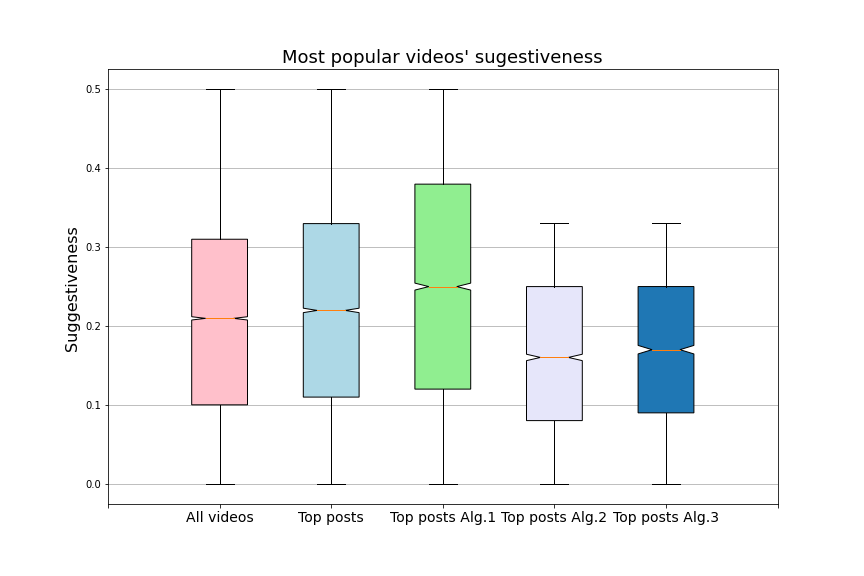

In [17]:
from PIL import Image

# Get the private asset reference
asset = researcher_client.datasets[0].assets[0]

# Compute the result on the private asset, as it was approved
result = researcher_client.code.suggestiveness_in_top10pp_videos(df=asset)

Image.open(result.get())

## Result for the 2nd code request

In [18]:
researcher_client.code.get_outliers(df=asset)

,suggestive,algo,recommendations,title,desc,tags,distance
7827,0.33,C,99744.0,show 1998 Cloud Episode friends Syria الحلقة S...,and /><br also />Musique ministre fire /><br /...,بوراك,6.089757


# The End!

## Researcher can submit follow up requests or wrap it up. 

## Wrap up process:
- the researcher presents their findings to the organisation
- if the research findings raise specific issues in the behaviour of the AI algorithms, the company can work to improve their systems accordingly.

Now, let's see how real outcomes of such a study look like.
<!-- # Thank you!


## We invite you now to conduct your own audit on Linkedin's and DailyMotion's node.

Steps:
1. Download the notebooks available here: ...
2. Follow the installation instructions
3. Creatively propose questions that can be answered with the data! -->